In [55]:
## Set-up.
### Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [93]:
! pip freeze > '../requirements.txt'

In [56]:
DATA_PATH = '../dataset/'

In [57]:
data = pd.read_parquet(os.path.join(DATA_PATH,'data_eng.gzip'))

In [58]:
data.head()

,age,gender,education,class,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,income_above_limit,investments
0,63+,Female,highschool,NA,Widowed,White,No,Unemployed,0,0_10,weeks_worked_48_52,Not in universe or children,NA,Householder,2,Head of household,Native,0,True
1,63+,Female,highschool,NA,Widowed,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,0,False
2,18_24,Male,no_highschool,Federal government,Never married,Black,No,Children or Armed Forces,0,101_500,weeks_worked_1_25,Hospital services,Adm support including clerical,Child 18 or older,2,Single,Native,0,False
4,63+,Male,highschool,NA,Married-civilian spouse present,White,No,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint both 65+,Native,0,False
5,33_45,Male,bachelors,Private,Married-civilian spouse present,Asian or Pacific Islander,No,Children or Armed Forces,0,501_1000,weeks_worked_48_52,Retail trade,Other service,Householder,2,Joint both under 65,Foreign born- Not a citizen of U S,0,False


In [59]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [60]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('income_above_limit', axis=1), data['income_above_limit'], test_size=0.3, random_state=12345)

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = Pipeline(
    steps=[
        ('impute',SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown="ignore"))
        ]
)

In [62]:
X_tr_pr = preprocessor.fit_transform(X_train)

In [63]:
X_tst_pr = preprocessor.transform(X_test)

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as ROC

def dmp_first_classifier(model, train_x, train_y, test_x, test_y, parameters ={}):
    classifier = model()
    if len(parameters.items())>0:
        searcher = GridSearchCV(classifier, parameters, cv=5)
        searcher.fit(train_x, train_y)
        print(f'Model {model}')
        print("Best CV params", searcher.best_params_)
        #print("Test accuracy of best grid search hypers:", searcher.score(test_x, test_y))
        best_model = searcher.best_estimator_
    else: best_model = classifier
    best_model.fit(train_x, train_y)
    print("Test accuracy of best grid search hypers:", best_model.score(test_x, test_y))
    return best_model

In [36]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {}
best_lrg = dmp_first_classifier(lrg, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.9312188010778814


In [42]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier
parameters = {}
best_knc = dmp_first_classifier(knc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.9217652515792729


In [40]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier
parameters = {}
best_rfc = dmp_first_classifier(rfc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.9255864292971684


In [37]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier
parameters = {}
best_sgdc = dmp_first_classifier(sgdc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)


Test accuracy of best grid search hypers: 0.9240623757565049


In [41]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier
parameters = {}
best_gbc = dmp_first_classifier(gbc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.9309095728232539


In [38]:
import xgboost as xgb
xgbc = xgb.XGBClassifier
parameters = {}
best_xgbc = dmp_first_classifier(xgbc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)



Test accuracy of best grid search hypers: 0.9321243981092902


In [43]:
from sklearn import metrics

def score_model(model, X, y):
    predicted = model.predict(X)
    probs = model.predict_proba(X)
    
    # Generate and display different evaluation metrics
    print(metrics.accuracy_score(y, predicted))
    print(metrics.roc_auc_score(y, probs[:, 1]))
    
    print(metrics.confusion_matrix(y, predicted))
    print(metrics.classification_report(y, predicted))

In [44]:
score_model(best_xgbc, X_tst_pr, y_test)

0.9321243981092902
0.9163243228760418
[[40683   748]
 [ 2325  1518]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     41431
           1       0.67      0.40      0.50      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.69      0.73     45274
weighted avg       0.92      0.93      0.92     45274


In [65]:
upsample_training = X_train.copy()
upsample_training['Y'] = y_train

In [66]:
bellow = upsample_training.loc[upsample_training.Y==0]
above = upsample_training.loc[upsample_training.Y==1]

In [67]:
from sklearn.utils import resample
above_upsample = resample(above,
             replace=True,
             n_samples=len(bellow),
             random_state=12345)

In [68]:
print(bellow.shape)
print(above_upsample.shape)

(96485, 19)
(96485, 19)


In [69]:
data_upsample = pd.concat([bellow, above_upsample])
data_upsample.head()

,age,gender,education,class,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,investments,Y
87286,63+,Female,masters,NA,Never married,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,False,0
78624,46_62,Female,highschool,NA,Married-civilian spouse present,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint one under 65 & one 65+,Native,False,0
2842,63+,Male,no_highschool,NA,Married-civilian spouse present,White,No,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Joint both 65+,Native,False,0
88532,46_62,Female,highschool,Private,Never married,White,No,Full-time schedules,2,0_10,weeks_worked_48_52,Retail trade,Adm support including clerical,Child 18 or older,2,Single,Native,False,0
10009,46_62,Female,somecollege,Private,Divorced,White,No,Children or Armed Forces,0,0_10,weeks_worked_48_52,Social services,Professional specialty,Householder,2,Head of household,Native,False,0


In [70]:
X_train_up = data_upsample.drop('Y', axis=1)
y_train_up = data_upsample.Y

In [71]:
X_train_up_pr = preprocessor.transform(X_train_up)

In [72]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {}
best_lrg_up = dmp_first_classifier(lrg, X_train_up_pr, y_train_up, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.8299907231523612


In [73]:
import xgboost as xgb
xgbc = xgb.XGBClassifier
parameters = {}
best_xgbc_up = dmp_first_classifier(xgbc, X_train_up_pr, y_train_up, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.8463577329151389


In [95]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier
parameters = {}
best_rfc_up = dmp_first_classifier(rfc, X_train_up_pr, y_train_up, X_tst_pr, y_test, parameters)

Test accuracy of best grid search hypers: 0.899302027653841


In [74]:
score_model(best_xgbc_up, X_tst_pr, y_test)

0.8463577329151389
0.9134371483643887
[[35157  6274]
 [  682  3161]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     41431
           1       0.34      0.82      0.48      3843

    accuracy                           0.85     45274
   macro avg       0.66      0.84      0.69     45274
weighted avg       0.93      0.85      0.87     45274


In [75]:
score_model(best_xgbc, X_tst_pr, y_test)

0.9321243981092902
0.9163243228760418
[[40683   748]
 [ 2325  1518]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     41431
           1       0.67      0.40      0.50      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.69      0.73     45274
weighted avg       0.92      0.93      0.92     45274


In [91]:
score_model(best_lrg, X_tst_pr, y_test)

0.9312188010778814
0.9144887857305619
[[40788   643]
 [ 2471  1372]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.68      0.36      0.47      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.67      0.72     45274
weighted avg       0.92      0.93      0.92     45274


In [92]:
score_model(best_lrg_up, X_tst_pr, y_test)

0.8299907231523612
0.9143028849392304
[[34313  7118]
 [  579  3264]]
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     41431
           1       0.31      0.85      0.46      3843

    accuracy                           0.83     45274
   macro avg       0.65      0.84      0.68     45274
weighted avg       0.93      0.83      0.86     45274


In [94]:
score_model(best_rfc, X_tst_pr, y_test)

0.9255864292971684
0.8805177854877709
[[40536   895]
 [ 2474  1369]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.60      0.36      0.45      3843

    accuracy                           0.93     45274
   macro avg       0.77      0.67      0.70     45274
weighted avg       0.91      0.93      0.92     45274


In [81]:
y_score = best_xgbc.predict_proba(X_tst_pr)

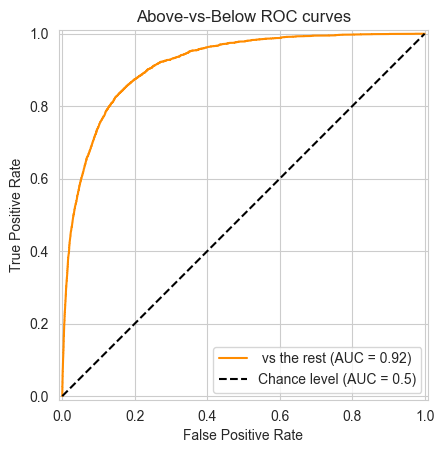

In [90]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Above-vs-Below ROC curves",
)

In [86]:
y_score_up = best_xgbc_up.predict_proba(X_tst_pr)

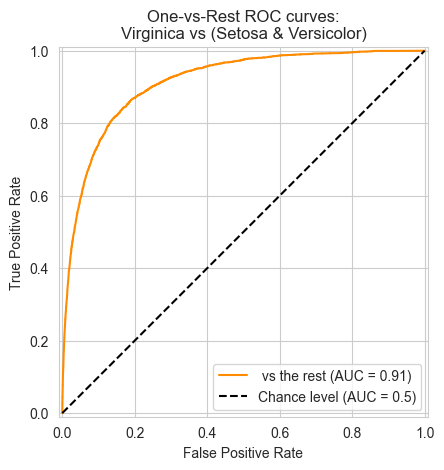

In [87]:
display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score_up[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)